### SVC Model with SCFP for the target ER2/MAPK1

In [24]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
import seaborn as sns
from neutralize import NeutraliseCharges
import sys
import deepchem as dc
import numpy as np
from rdkit.Chem.rdmolfiles import MolToSmiles
from tqdm.auto import tqdm
import cupy as cp
from chainer import serializers
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
  
sys.path.append('../')
from SCFP_functions.feature import *
import SCFP_functions.SCFPfunctions as Mf
import SCFP_functions.SCFPmodel as Mm
from SCFP_functions.constants import lensize
from SCFP_functions.constants import scfp_model_args as args

### Exploratory data analysis (EDA)

In [2]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol] # molecular weight
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol] # charge

In [3]:
# active molecules
active_df = pd.read_csv("../data/dud-e_ERK2_MAPK1/actives_final.ism",header=None,sep=" ")
active_rows, active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")
add_property_columns_to_df(active_df)

# inactive molecules
decoy_df = pd.read_csv("../data/dud-e_ERK2_MAPK1/decoys_final.ism",header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

In [4]:
tmp_df = active_df.append(decoy_df)

C:\Users\gabriel\AppData\Local\Temp\ipykernel_24784\3353245068.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp_df = active_df.append(decoy_df)


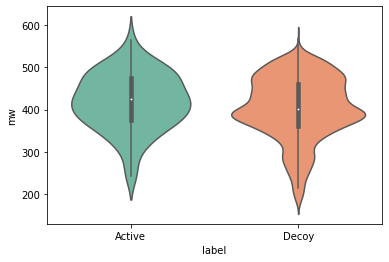

In [5]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["mw"],palette="Set2");

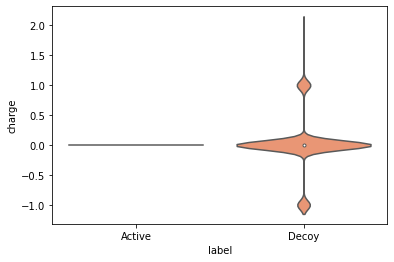

In [6]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["charge"],palette="Set2");

In [7]:
#neutralize molecules from the decoy set
charged = decoy_df[decoy_df["charge"] != 0]
print("before:", charged.shape[0]/decoy_df.shape[0])
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
print("after:", charged.shape[0]/revised_decoy_df.shape[0])

before: 0.16175824175824177
after: 0.0026373626373626374


In [8]:
new_tmp_df = active_df.append(revised_decoy_df)

C:\Users\gabriel\AppData\Local\Temp\ipykernel_24784\2430610062.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_tmp_df = active_df.append(revised_decoy_df)


<AxesSubplot:xlabel='label', ylabel='charge'>

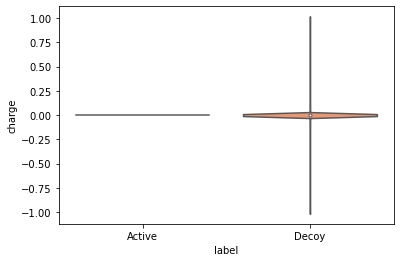

In [9]:
sns.violinplot(x=new_tmp_df["label"],y=new_tmp_df["charge"],palette="Set2")

In [10]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","is_active"]]
combined_df.head()

C:\Users\gabriel\AppData\Local\Temp\ipykernel_24784\2633738906.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = active_df.append(revised_decoy_df)[["SMILES","is_active"]]


,SMILES,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,1


In [11]:
# save combined data to csv
combined_df.to_csv("../data/dud-e_ERK2_MAPK1/data_combined.csv", index=False, sep="\t", header=None)

### Model: Training

In [12]:
#-------------------------------
# GPU check
xp = np
if args["gpu"] >= 0:
    print('GPU mode')
    xp = cp

GPU mode


In [13]:
file='../data/dud-e_ERK2_MAPK1/data_combined.csv'
print('Loading smiles: ', file)
smi = Chem.SmilesMolSupplier(file,delimiter='\t',titleLine=False)
mols = [mol for mol in smi if mol is not None]
smiles = [MolToSmiles(smiles) for smiles in mols]

F_list, T_list = [],[]
for mol in mols:
    if len(Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)) > args["atomsize"]: print("SMILES is too long. This mol will be ignored.")
    else:
        F_list.append(mol_to_feature(mol,-1,args["atomsize"]))
        T_list.append(mol.GetProp('_Name') )            
Mf.random_list(F_list)
Mf.random_list(T_list)
data_t = np.asarray(T_list, dtype=np.int32).reshape(-1,1)
data_f = np.asarray(F_list, dtype=np.float32).reshape(-1,1,args["atomsize"],lensize)
print(data_t.shape, data_f.shape)

Loading smiles:  ../data/dud-e_ERK2_MAPK1/data_combined.csv
(4629, 1) (4629, 1, 400, 42)


In [14]:
vectorizer_model = Mm.CNN(args["atomsize"], lensize, args["k1"], args["s1"], args["f1"], args["k2"], args["s2"], args["k3"], args["s3"], args["f3"],args["k4"], args["s4"],args["n_hid"],args["n_out"])

In [15]:
def vectorize():
    data_x = []
    data_y = []

    with cp.cuda.Device(args["gpu"]):
        serializers.load_npz('../model_output/model_snapshot_500', vectorizer_model)

    for index, x in enumerate(data_f):
        # x
        scfp = vectorizer_model.fingerprint(x).flatten()
        data_x.append(np.array(scfp))
        # y
        y = data_t[index].flatten()
        data_y.append(np.array(y))
    return  dc.data.NumpyDataset(X=data_x, y=data_y, ids=smiles)

dataset = vectorize()

In [16]:
splitter = dc.splits.RandomStratifiedSplitter()
metrics_arr = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)]

In [17]:
def model_builder(model_dir):
  class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(dataset.y.flatten()), y=dataset.y.flatten())
  sklearn_model = SVC(class_weight={0: class_weights[0], 1: class_weights[1]})
  return dc.models.SklearnModel(sklearn_model, model_dir)

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

[0.9411630036630036, 0.9587912087912087, 0.9556623931623932, 0.9587912087912087, 0.9477258852258853]
[0.6457417582417582, 0.8913461538461538, 0.8957417582417582, 0.8343406593406593, 0.7828296703296702]


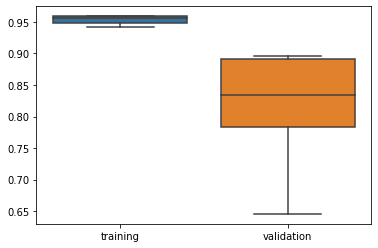

In [18]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in tqdm(range(0,cv_folds)):
    model = model_builder('./model_dir')
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics_arr, transformers)
    training_score_list.append(train_scores["mean-roc_auc_score"])
    validation_scores = model.evaluate(valid_dataset, metrics_arr, transformers)
    validation_score_list.append(validation_scores["mean-roc_auc_score"])
print(training_score_list)
print(validation_score_list)

sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

In [19]:
model = model_builder('./model_dir')
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,seed=42)
model.fit(train_dataset)

### Model: Testing

false_negative: 1
true_positive: 7
false_positive: 43
true_negative: 412
recall: 0.9049676025917927
precision 0.9049676025917927
f1: 0.9049676025917927
roc-auc: 0.8902472527472527


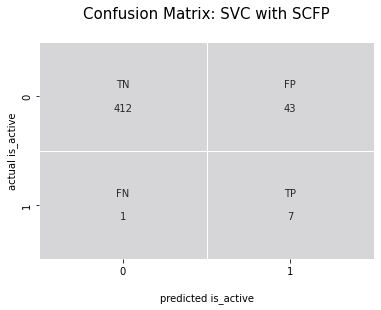

In [23]:
pred = [x.flatten() for x in model.predict(test_dataset)]
pred_df = pd.DataFrame(pred,columns=["prediction"])
pred_df["active"] = [int(x) for x in test_dataset.y]
pred_df["SMILES"] = test_dataset.ids

false_negative_df = pred_df.query("active == 1 & prediction == 0").copy()
true_positive_df = pred_df.query("active == 1 & prediction == 1").copy()
false_positive_df = pred_df.query("active == 0 & prediction == 1").copy()
true_negative_df = pred_df.query("active == 0 & prediction == 0").copy()
print("false_negative:", false_negative_df.shape[0])
print("true_positive:", true_positive_df.shape[0])
print("false_positive:", false_positive_df.shape[0])
print("true_negative:", true_negative_df.shape[0])

recall = recall_score(test_dataset.y.flatten(), pred, average='micro')
precision = precision_score(test_dataset.y.flatten(), pred, average='micro')
f1 = f1_score(test_dataset.y.flatten(), pred, average='micro')
auc = roc_auc_score(test_dataset.y.flatten(), pred, average='micro')
print("recall:", recall)
print("precision", precision)
print("f1:", f1)
print("roc-auc:", auc)

cf_matrix = confusion_matrix(test_dataset.y.flatten(), pred)
group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, linecolor="white", linewidths=.5, fmt='', cmap=["#d6d6d9"], cbar=False)

ax.set_title('Confusion Matrix: SVC with SCFP\n',fontsize=15);
ax.set_xlabel('\npredicted is_active')
ax.set_ylabel('actual is_active');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()
savefigure = ax.get_figure()
savefigure.savefig('../results/confusion_matrix_svc_ERK2.png', format='png', dpi=1000, bbox_inches='tight')